In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# !pip3 install geopandas
# !pip3 install osmnx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None 

In [25]:
data_path = os.path.join(os.path.abspath(os.getcwd()), "Dataset")
data_path

'/content/Dataset'

In [26]:
# get store data
jul = pd.read_csv("/content/drive/MyDrive/Urban Data Final Project/core_poi-patterns-1.csv")
aug = pd.read_csv("/content/drive/MyDrive/Urban Data Final Project/core_poi-patterns-2.csv")
sep = pd.read_csv("/content/drive/MyDrive/Urban Data Final Project/core_poi-patterns-3.csv")

df = pd.concat([jul, aug, sep])
locations = [df['latitude'], df['longitude']]
print(locations)

[0       40.791825
1       40.750793
2       40.721632
3       40.769184
4       40.800974
          ...    
1465    40.707812
1466    40.754531
1467    40.739389
1468    40.753106
1469    40.778031
Name: latitude, Length: 4306, dtype: float64, 0      -73.974250
1      -73.984801
2      -74.000622
3      -73.952321
4      -73.967513
          ...    
1465   -74.009611
1466   -73.994531
1467   -73.992894
1468   -73.993083
1469   -73.903486
Name: longitude, Length: 4306, dtype: float64]


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4306 entries, 0 to 1469
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   placekey                   4306 non-null   object 
 1   parent_placekey            870 non-null    object 
 2   location_name              4306 non-null   object 
 3   safegraph_brand_ids        721 non-null    object 
 4   brands                     721 non-null    object 
 5   top_category               4306 non-null   object 
 6   sub_category               4306 non-null   object 
 7   category_tags              0 non-null      float64
 8   naics_code                 4306 non-null   int64  
 9   latitude                   4306 non-null   float64
 10  longitude                  4306 non-null   float64
 11  street_address             4306 non-null   object 
 12  city                       4306 non-null   object 
 13  region                     4306 non-null   objec

In [28]:
df = df[["brands",
	"latitude",
	"longitude",
	# "city",
	# "date_range_start",
	# "date_range_end",
	# "visits_by_day",
	# "open_hours",
	"raw_visitor_counts"]]
	
df = df.dropna()
df

,brands,latitude,longitude,raw_visitor_counts
0,SoulCycle,40.791825,-73.974250,32.0
5,Equinox Fitness Clubs,40.759739,-73.975446,29.0
9,Wundabar Pilates,40.773119,-73.956233,20.0
11,Equinox Fitness Clubs,40.791939,-73.974148,69.0
18,CorePower Yoga,40.739206,-73.993740,124.0
...,...,...,...,...
1440,Equinox Fitness Clubs,40.722231,-73.987651,229.0
1449,Flywheel,40.730141,-73.990245,228.0
1462,Physique57,40.763456,-73.974439,147.0
1464,Planet Fitness,40.847257,-73.937752,104.0


In [29]:
# compute each point's visits per month
new_df = df.groupby(['latitude','longitude'])['raw_visitor_counts'].agg(['sum','count'])
new_df['visits_per_month'] = new_df['sum']//new_df['count']
new_df
# print(new_df['visits_per_month'])
new_df['visits_per_month'].describe()

count     245.000000
mean      119.853061
std       134.400562
min         1.000000
25%        45.000000
50%        81.000000
75%       160.000000
max      1182.000000
Name: visits_per_month, dtype: float64

In [30]:
# get geo dataframe

tags = {'amenity':['fast_food', 'school', 'bank']}
point = (40.756253, -73.977401)
dist = 1000
geo = osmnx.geometries_from_point(point, tags, dist=dist)

In [31]:
# entire New York dataframe
ACS_2012_5YR_TRACT_36_NEW_YORK = gpd.read_file('/content/drive/MyDrive/Urban Data Final Project/ACS_2012_5YR_TRACT_36_NEW_YORK.gdb', layer='ACS_2012_5YR_TRACT_36_NEW_YORK')

# only get New York City
polydf = ACS_2012_5YR_TRACT_36_NEW_YORK.loc[ACS_2012_5YR_TRACT_36_NEW_YORK['COUNTYFP'].isin(['061'])]

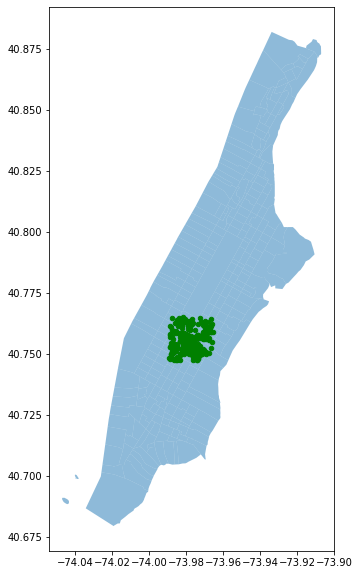

In [32]:
def plot_nearby():
  # temp = gpd.sjoin(geo, polydf, how='left', op="intersects")
    geo.crs = polydf.crs
    fig, ax = plt.subplots(figsize = (10, 10))
    polydf.plot(ax=ax, column='COUNTYFP', alpha=0.5)
    geo.plot(ax=ax, markersize=20, color='green')

plot_nearby()

In [33]:
tags = {'amenity':['fast_food', 'school', 'bank', 'nightclub'], 
        'building':['religious', 'hosipital'], 
        'shop':['bakery','coffee','beverage','department_store','mall','massage','tattoo'], 
        'sport':['aikido','judo','wrestling','karate','sumo','taekwondo'], 'tourism': True}

geo = osmnx.geometries_from_point(
    (40.756253, -73.977401),
    tags,
    dist=500
)

geo.groupby(geo['amenity']).count()['geometry']

amenity
bank                40
fast_food           57
library              1
place_of_worship     1
school               2
telephone            3
theatre              1
Name: geometry, dtype: int64

In [34]:
tags_full = {'amenity':['fast_food', 'school', 'bank', 'nightclub', 'bus_station', 'taxi'],
        'building':['religious', 'hosipital'],
        'shop':['bakery','coffee','beverage','department_store','mall','massage','tattoo'],
        'sport':['aikido','judo','wrestling','karate','sumo','taekwondo'],
        'tourism': True,
        'public_transport':True,
        'railway':True

        }
tags = {'amenity':['fast_food', 'school', 'bank', 'nightclub']}

In [13]:
# iterate the store points to get location tags
cnt = 0
for point,row in new_df.iterrows():
    dist = 500
    geo = osmnx.geometries_from_point(point, tags_full, dist)
    attrs = ['amenity','shop','sport','tourism', 'public_transport', 'railway']
    for attr in attrs:
        if attr in geo:
            ind_list = geo[attr].value_counts().index.to_list()
            val_list = geo[attr].value_counts().to_list()
            for ind, val in zip(ind_list,val_list):
                if ind not in new_df:
                    new_df[ind] = 0
                new_df[ind][point] = val
    cnt += 1
    print('done'+str(point), str(cnt)+ ' out of' +  str(len(new_df)) + ' done!')

done(40.567149, -74.112941) 1 out of245 done!
done(40.668707, -73.986321) 2 out of245 done!
done(40.668902, -73.986174) 3 out of245 done!
done(40.668916, -73.986171) 4 out of245 done!
done(40.677499, -73.980066) 5 out of245 done!


/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


done(40.685016, -73.994833) 6 out of245 done!


/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


done(40.692106, -73.990991) 7 out of245 done!
done(40.702072, -74.011873) 8 out of245 done!
done(40.705237, -74.016129) 9 out of245 done!
done(40.70543, -74.001127) 10 out of245 done!
done(40.705459, -74.012293) 11 out of245 done!
done(40.705983, -74.013457) 12 out of245 done!
done(40.706272, -74.011651) 13 out of245 done!
done(40.70632, -74.012552) 14 out of245 done!
done(40.706349, -74.006529) 15 out of245 done!
done(40.707114, -74.007006) 16 out of245 done!
done(40.707139, -74.013091) 17 out of245 done!
done(40.707208, -74.013062) 18 out of245 done!
done(40.707237, -74.013033) 19 out of245 done!
done(40.707783, -74.010523) 20 out of245 done!
done(40.707812, -74.009611) 21 out of245 done!
done(40.708369, -74.007177) 22 out of245 done!
done(40.708693, -74.010172) 23 out of245 done!
done(40.709695, -74.006165) 24 out of245 done!
done(40.710891, -74.007355) 25 out of245 done!
done(40.712054, -74.015158) 26 out of245 done!
done(40.713857, -74.009793) 27 out of245 done!
done(40.713958, -7

In [14]:
new_df.columns

Index(['sum', 'count', 'visits_per_month', 'school', 'bank', 'fast_food',
       'platform', 'dojo', 'taxi', 'massage', 'ice_cream', 'coffee', 'bakery',
       'tattoo', 'taekwondo', 'judo', 'karate', 'aikido', 'gallery', 'hotel',
       'museum', 'stop_position', 'station', 'subway', 'switch',
       'subway_entrance', 'stop', 'railway_crossing', 'cafe', 'bar', 'clothes',
       'events_venue', 'department_store', 'apartment', 'attraction',
       'abandoned', 'restaurant', 'bus_station', 'telephone', 'artwork',
       'information', 'yes', 'buffer_stop', 'ferry_terminal', 'convenience',
       'viewpoint', 'ventilation_shaft', 'razed', 'disused', 'stock_exchange',
       'place_of_worship', 'service_station', 'mall', 'skateboard',
       'fire_station', 'pastry', 'nightclub', 'hostel', 'ticket',
       'arts_centre', 'aquarium', 'chalet', 'college',
       'wifi;telephone;device_charging_station', 'picnic_site', 'rail',
       'milestone', 'multi', 'no', 'construction', 'service_cent

In [15]:
new_df = new_df[['sum', 'count', 'visits_per_month', 'subway', 'school', 'bank',
       'fast_food', 'platform', 'dojo', 'taxi', 'massage', 'ice_cream',
       'coffee', 'bakery', 'tattoo', 'taekwondo', 'judo', 'karate', 'aikido',
       'gallery', 'hotel', 'museum', 'stop_position', 'station', 'switch',
       'subway_entrance', 'stop', 'railway_crossing', 'cafe', 'bar', 'clothes',
       'events_venue', 'department_store', 'apartment', 'attraction',
       'abandoned', 'restaurant', 'bus_station', 'telephone', 'artwork',
       'information', 'yes', 'buffer_stop', 'ferry_terminal', 'convenience',
       'viewpoint', 'ventilation_shaft', 'razed', 'disused', 'stock_exchange',
       'place_of_worship', 'service_station', 'mall', 'skateboard',
       'fire_station', 'pastry', 'nightclub', 'hostel', 'ticket',
       'arts_centre', 'aquarium', 'chalet', 'college',
       'wifi;telephone;device_charging_station', 'picnic_site', 'rail',
       'milestone', 'multi', 'no', 'construction', 'service_center', 'library',
       'derail', 'proposed', 'sightseeing', 'ice_skating', 'theatre',
       'junction', 'cinema', 'motel', 'zoo', 'theme_park', 'clock', 'gift',
       'fountain', 'optician', 'guest_house']]

print(new_df)

                         sum  count  ...  optician  guest_house
latitude  longitude                  ...                       
40.567149 -74.112941   596.0      3  ...         0            0
40.668707 -73.986321   227.0      1  ...         0            0
40.668902 -73.986174     1.0      1  ...         0            0
40.668916 -73.986171   184.0      1  ...         0            0
40.677499 -73.980066    35.0      3  ...         0            0
...                      ...    ...  ...       ...          ...
40.823563 -73.837324  3548.0      3  ...         0            0
40.834594 -73.944896   275.0      3  ...         0            1
40.839839 -73.917611   657.0      3  ...         0            0
40.847257 -73.937752   375.0      3  ...         0            0
40.848586 -73.936927   947.0      3  ...         0            0

[245 rows x 87 columns]


In [16]:
#standardization
y = new_df['visits_per_month']
new_df = (new_df - new_df.mean()) / new_df.std()


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X = new_df.loc[ : , ~new_df.columns.isin(['visits_per_month', 'sum', 'count'])]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

#linear model
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
linear_pred = reg.predict(X_val)
print(reg.score(X_train, y_train))
print(r2_score(y_val, linear_pred))

#random forest
random_forest = RandomForestRegressor(min_samples_leaf=4, max_leaf_nodes=15, max_features='auto').fit(X_train, y_train)
print(random_forest.score(X_train, y_train))
pred = random_forest.predict(X_val)
print(r2_score(y_val, pred))

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.5010182725380699
-2.3420618768305115e+19
0.5098068353306415
0.2240398672687003


In [18]:
locations = [(40.735490680487295, -73.9929921189605),
             (40.753127135716895, -73.99060237919237),
             (40.74540657493507, -73.99368604424726),
             (40.780089796366646, -73.95527034053846)]
# iterate the store points to get location tags

test = pd.read_csv('/content/drive/MyDrive/Urban Data Final Project/test_df.csv')
# test_df = test.groupby(['latitude','longitude'])
test_idx = []
for index, row in test.iterrows():
    test_idx.append((row["latitude"], row["longitude"]))
test["idx"] = pd.Series(test_idx)

cnt = 0
test = test[:4]
test = test[['idx']]

print(test)

                           idx
0  (40.73549068, -73.99299212)
1  (40.75312714, -73.99060238)
2  (40.74540657, -73.99368604)
3   (40.7800898, -73.95527034)


In [19]:
for col in new_df.columns:
    if col not in test.columns:
        test[col] = 0
test = test.drop(columns=['idx','sum','count','visits_per_month'])
# test.set_index("idx", inplace=True)
test.reset_index()

,index,subway,school,bank,fast_food,platform,dojo,taxi,massage,ice_cream,coffee,bakery,tattoo,taekwondo,judo,karate,aikido,gallery,hotel,museum,stop_position,station,switch,subway_entrance,stop,railway_crossing,cafe,bar,clothes,events_venue,department_store,apartment,attraction,abandoned,restaurant,bus_station,telephone,artwork,information,yes,...,razed,disused,stock_exchange,place_of_worship,service_station,mall,skateboard,fire_station,pastry,nightclub,hostel,ticket,arts_centre,aquarium,chalet,college,wifi;telephone;device_charging_station,picnic_site,rail,milestone,multi,no,construction,service_center,library,derail,proposed,sightseeing,ice_skating,theatre,junction,cinema,motel,zoo,theme_park,clock,gift,fountain,optician,guest_house
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
for lo_ind, point in enumerate(locations):
    dist = 500
    geo = osmnx.geometries_from_point(point, tags_full, dist)
    attrs = ['amenity','shop','sport','tourism', 'public_transport', 'railway']
    for attr in attrs:
        if attr in geo:
            ind_list = geo[attr].value_counts().index.to_list()
            val_list = geo[attr].value_counts().to_list()
            # print(val_list)
            for ind, val in zip(ind_list,val_list):
                # print('-----', test[ind])
                # test[ind][point]= val
                test[ind][lo_ind] = val
                # print(test[ind][point])
    cnt += 1
    print('done'+str(point), str(cnt)+ ' out of' +  str(len(test)) + ' done!')
print('test', test)
# print(test_df)
# reg.predict(test)

model = random_forest.predict(test)

done(40.735490680487295, -73.9929921189605) 1 out of4 done!
done(40.753127135716895, -73.99060237919237) 2 out of4 done!
done(40.74540657493507, -73.99368604424726) 3 out of4 done!
done(40.780089796366646, -73.95527034053846) 4 out of4 done!
test    subway  school  bank  fast_food  ...  gift  fountain  optician  guest_house
0      46      13    19         40  ...     0         0         0            0
1      77       0    14         71  ...     0         0         0            0
2      36       3    15         53  ...     0         0         0            0
3       8       9    14         17  ...     0         0         0            0

[4 rows x 84 columns]


|--- feature_10 <= -1.06
|   |--- feature_30 <= 0.36
|   |   |--- value: [179.82]
|   |--- feature_30 >  0.36
|   |   |--- value: [352.00]
|--- feature_10 >  -1.06
|   |--- feature_18 <= 1.86
|   |   |--- feature_1 <= -0.23
|   |   |   |--- feature_38 <= 0.32
|   |   |   |   |--- feature_10 <= -0.37
|   |   |   |   |   |--- value: [88.28]
|   |   |   |   |--- feature_10 >  -0.37
|   |   |   |   |   |--- value: [42.73]
|   |   |   |--- feature_38 >  0.32
|   |   |   |   |--- feature_37 <= 0.25
|   |   |   |   |   |--- value: [175.43]
|   |   |   |   |--- feature_37 >  0.25
|   |   |   |   |   |--- value: [79.25]
|   |   |--- feature_1 >  -0.23
|   |   |   |--- feature_35 <= 0.33
|   |   |   |   |--- feature_53 <= 0.42
|   |   |   |   |   |--- feature_18 <= -0.51
|   |   |   |   |   |   |--- feature_1 <= 1.28
|   |   |   |   |   |   |   |--- value: [51.62]
|   |   |   |   |   |   |--- feature_1 >  1.28
|   |   |   |   |   |   |   |--- value: [109.00]
|   |   |   |   |   |--- feature_18 >

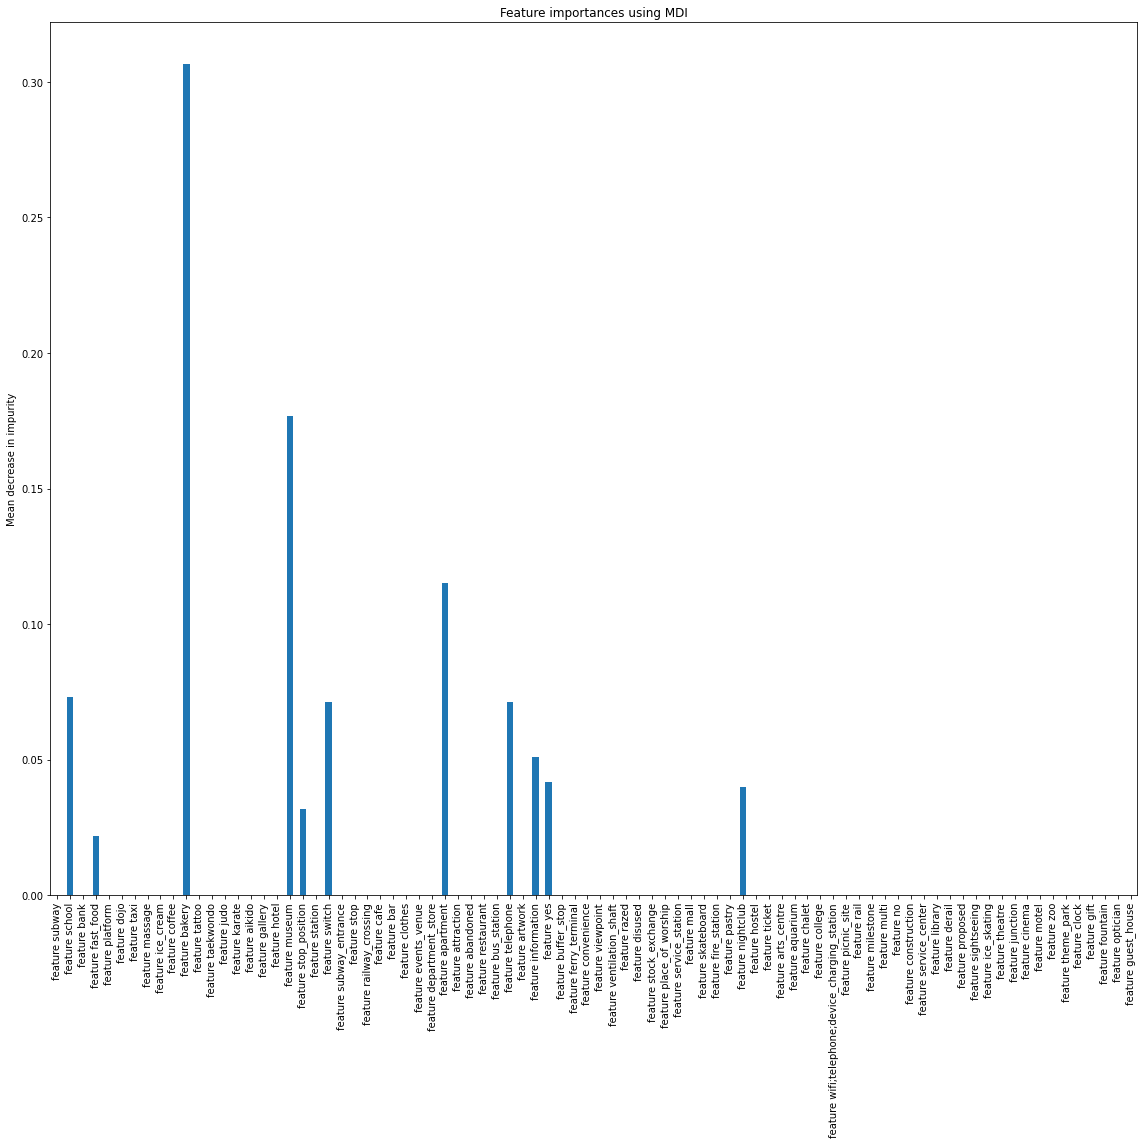

In [21]:
estimator = random_forest.estimators_[5]

from sklearn.tree import export_text
# Export as dot file
print(export_text(estimator))
'''
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')
'''
importances = estimator.feature_importances_
print(importances)
feature_names = [f"feature {i}" for i in test.columns]

print('--',feature_names)


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()

forest_importances.plot.bar(ax=ax, figsize=(16,16))
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

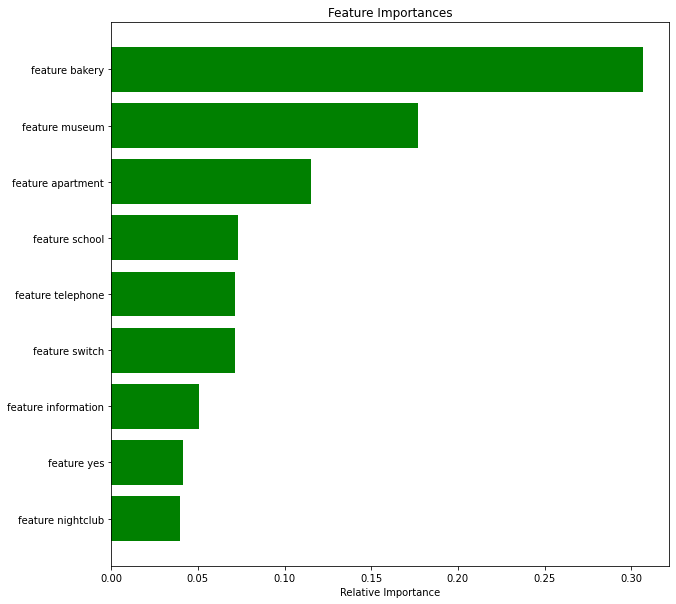

In [22]:
num_features = 9
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='g', align='center')
plt.yticks(range(num_features), [feature_names[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()